Import necessary libraries


In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report #  metrics
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

Read data

In [110]:
df_train = pd.read_csv('train_sections_data.csv', encoding='ISO-8859-1')
df_test = pd.read_csv('test_sections_data.csv', encoding='ISO-8859-1')

print(len(df_train))
print(len(df_test))

print('\nMissing values for train\n')
print(df_train.isna().sum())
print('\nMissing values for test\n')
print(df_test.isna().sum())

14215
1579

Missing values for train

Text                0
IsBold              0
IsItalic            0
IsUnderlined        0
Left                0
Right               0
Top                 0
Bottom              0
FontType            0
Label               0
Unnamed: 10     14215
Unnamed: 11     14215
Unnamed: 12     14214
dtype: int64

Missing values for test

Text            0
IsBold          0
IsItalic        0
IsUnderlined    0
Left            0
Right           0
Top             0
Bottom          0
FontType        0
Label           0
dtype: int64


In [111]:
df_train.columns

Index(['Text', 'IsBold', 'IsItalic', 'IsUnderlined', 'Left', 'Right', 'Top',
       'Bottom', 'FontType', 'Label', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')

In [112]:
columns = ['Text', 'IsBold', 'IsItalic', 'IsUnderlined', 'Left', 'Right', 'Top',
       'Bottom', 'FontType', 'Label']

df_train = df_train[columns]

df_test = df_test[columns]

In [113]:
def print_df_info(df):

    print(df.info())

    print('-----------------')

    print('Printing describe: \n', df.describe())

    print('-----------------')
    print('Missing value for train data: \n', df_train.isna().sum()/len(df_train))

    print('-----------------')
    print('Value counts: \n', df.value_counts())

    print('-----------------')

    print('Printing data types: \n', df.dtypes)

print_df_info(df_train)
print_df_info(df_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14215 entries, 0 to 14214
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Text          14215 non-null  object 
 1   IsBold        14215 non-null  bool   
 2   IsItalic      14215 non-null  bool   
 3   IsUnderlined  14215 non-null  bool   
 4   Left          14215 non-null  float64
 5   Right         14215 non-null  float64
 6   Top           14215 non-null  float64
 7   Bottom        14215 non-null  float64
 8   FontType      14215 non-null  object 
 9   Label         14215 non-null  int64  
dtypes: bool(3), float64(4), int64(1), object(2)
memory usage: 819.2+ KB
None
-----------------
Printing describe: 
                Left         Right           Top        Bottom         Label
count  14215.000000  14215.000000  14215.000000  14215.000000  14215.000000
mean      71.077418    451.751952    285.437557    317.711894      0.259937
std       56.290498    270.240

In [114]:
df_train.tail()

,Text,IsBold,IsItalic,IsUnderlined,Left,Right,Top,Bottom,FontType,Label
14210,The scheme's assets comprise a Friends Provide...,False,False,False,36.6,553.1,575.5,594.9,New Times Roman,0
14211,Transaction and Litigation Costs,False,True,True,42.7,151.4,91.0,96.7,New Times Roman,1
14212,The weighted-average fair value of options gra...,False,False,False,33.1,806.9,106.1,121.3,New Times Roman,0
14213,The analysis of gross contractual cash flow di...,False,False,False,42.6,553.1,667.0,687.0,New Times Roman,0
14214,"the cost of lab supplies and acquiring, develo...",False,False,False,170.0,546.2,337.8,343.5,New Times Roman,0


Convert boolean values to integer

In [115]:
df_train[df_train.select_dtypes(include='bool').columns] = df_train.select_dtypes(include='bool').astype(int)
df_test[df_test.select_dtypes(include='bool').columns] = df_test.select_dtypes(include='bool').astype(int)

Exploratory Analysis

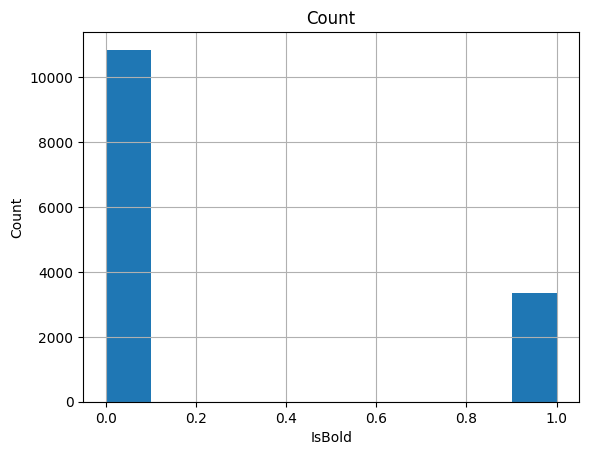

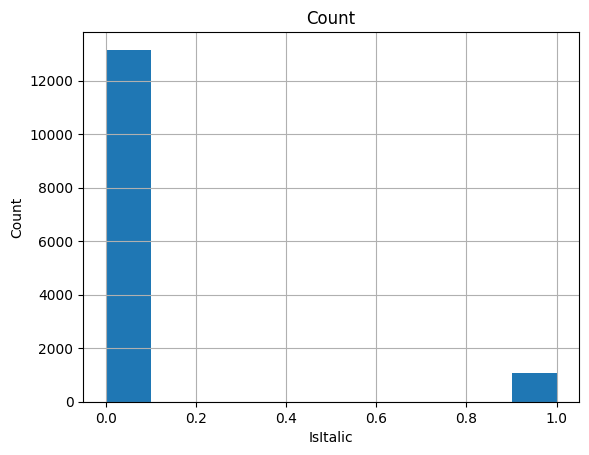

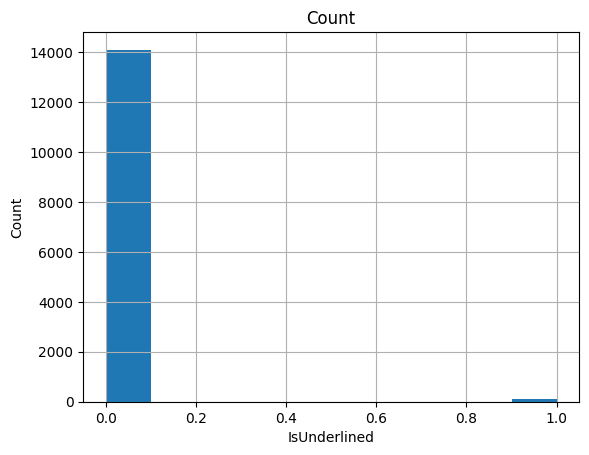

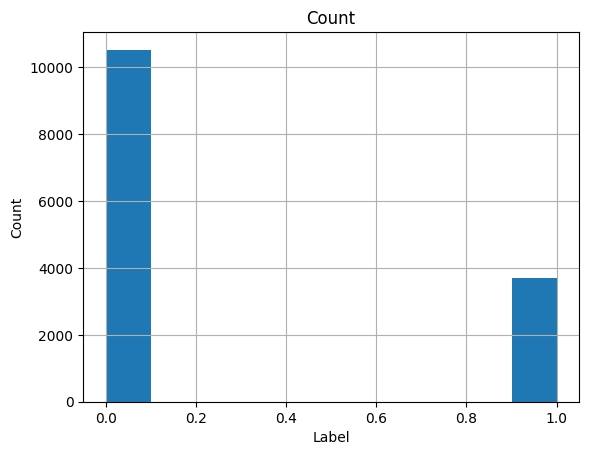

In [116]:
def barplot(feature):
    df_train[feature].hist()
    plt.title('Count')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

for column_name in df_train.select_dtypes(include='int64').columns:
  barplot(column_name)

In [117]:
df_train['FontType'].unique()

array(['New Times Roman'], dtype=object)

In [118]:
df_train = df_train.drop(['FontType'], axis=1)
df_test = df_test.drop(['FontType'], axis=1)

In [119]:
def add_new_feats(df):

  def percentage_upper_letters(text):
      total_chars = len(text)
      upper_chars = sum(1 for char in text if char.isupper())
      return (upper_chars / total_chars) * 100 if total_chars > 0 else 0

  def percentage_words_starting_upper(text):
      words = text.split()
      total_words = len(words)
      upper_start_words = sum(1 for word in words if word and word[0].isupper())
      return (upper_start_words / total_words) * 100 if total_words > 0 else 0

  def count_words(text):
    return len(text.split())

  # df['word_count'] = df['Text'].apply(lambda x: count_words(x))
  df['percent_alpha_numeric'] = df['Text'].apply(lambda x: sum(c.isalnum() for c in x) / len(x) * 100)
  df['percentage_upper_letters'] = df['Text'].apply(percentage_upper_letters)
  df['percentage_words_starting_upper'] = df['Text'].apply(percentage_words_starting_upper)
  df['text_length'] = df['Text'].apply(len)
  df['width'] = df['Right'] - df['Left']
  df['height'] = df['Bottom'] - df['Top']
  df['center_x'] = (df['Left'] + df['Right']) / 2
  df['center_y'] = (df['Top'] + df['Bottom']) / 2
  df['area'] = df['width'] * df['height']
  df['aspect_ratio'] = df['width'] / df['height']


  return df

df_train = add_new_feats(df_train)
df_test = add_new_feats(df_train)



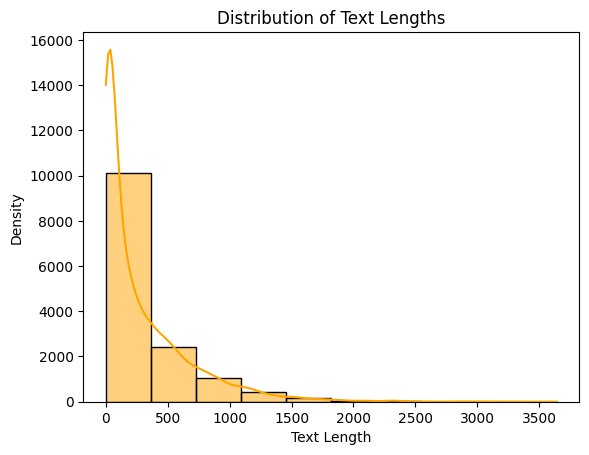

In [120]:

sns.histplot(df_train['text_length'], kde=True, color='orange', bins=10)
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.title('Distribution of Text Lengths')
plt.show()

In [121]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14215 entries, 0 to 14214
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Text                             14215 non-null  object 
 1   IsBold                           14215 non-null  int64  
 2   IsItalic                         14215 non-null  int64  
 3   IsUnderlined                     14215 non-null  int64  
 4   Left                             14215 non-null  float64
 5   Right                            14215 non-null  float64
 6   Top                              14215 non-null  float64
 7   Bottom                           14215 non-null  float64
 8   Label                            14215 non-null  int64  
 9   percent_alpha_numeric            14215 non-null  float64
 10  percentage_upper_letters         14215 non-null  float64
 11  percentage_words_starting_upper  14215 non-null  float64
 12  text_length       

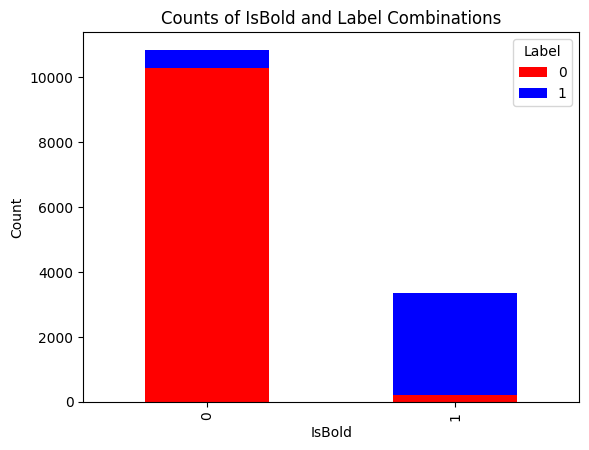

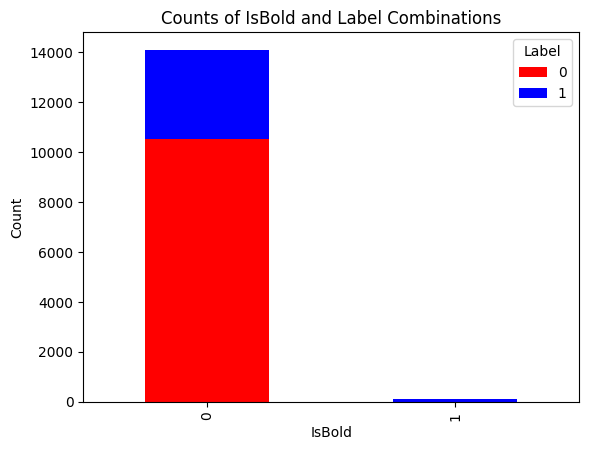

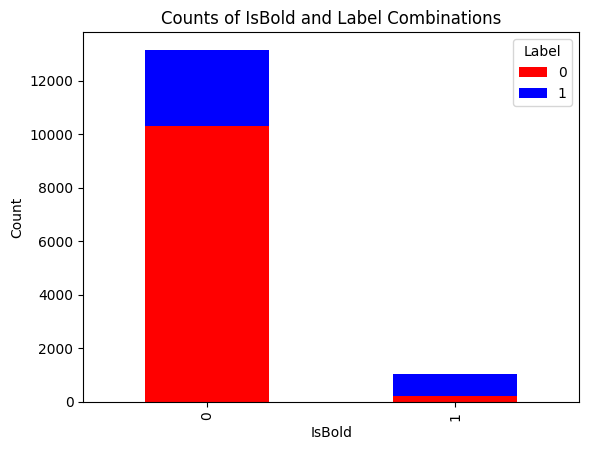

In [122]:
def plot_groupby(column_name):
  count_combinations = df_train.groupby([column_name, 'Label']).size().unstack(fill_value=0)

  count_combinations.plot(kind='bar', stacked=True, color=['red', 'blue'])
  plt.xlabel('IsBold')
  plt.ylabel('Count')
  plt.title('Counts of IsBold and Label Combinations')
  plt.legend(title='Label', loc='upper right')
  plt.show()


plot_groupby('IsBold')
plot_groupby('IsUnderlined')
plot_groupby('IsItalic')

In [123]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

title_word_len = df_train[df_train['Label']==1]['Text'].str.split().map(lambda x : len(x))
non_title_word_len = df_train[df_train['Label']==0]['Text'].str.split().map(lambda x : len(x))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Title", "Non-title"))

fig.add_trace(
            go.Histogram(x=title_word_len,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=1
).add_trace(
            go.Histogram(x=non_title_word_len,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=2
).update_layout(title_text="Length of words",title_x=0.5,showlegend=False).show()

In [124]:
import plotly.figure_factory as ff
import numpy as np

def avgwordlen(strlist):
    sum=[]
    for i in strlist:
        sum.append(len(i))
    return sum

avg_word_len1 = df_train[df_train['Label']==1]['Text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))
avg_word_len2 = df_train[df_train['Label']==0]['Text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

group_labels = ['Title', 'Non title']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot([avg_word_len1, avg_word_len2], group_labels, bin_size=.2, colors=colors,)

fig.update_layout(title_text="Average word length",title_x=0.5,xaxis_title="Text",yaxis_title="Density").show()


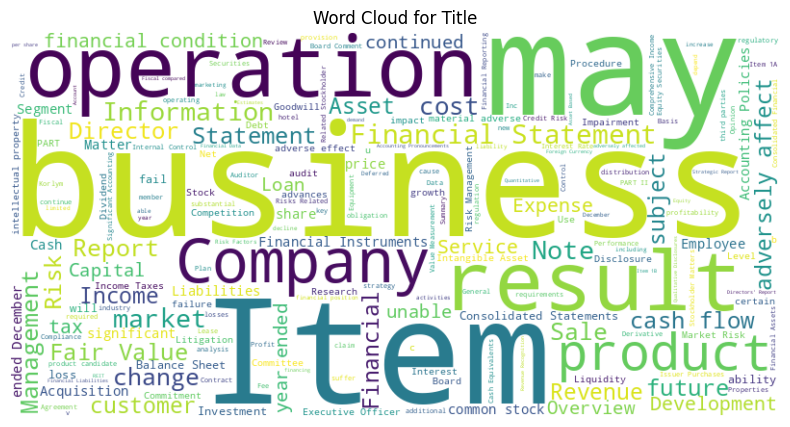

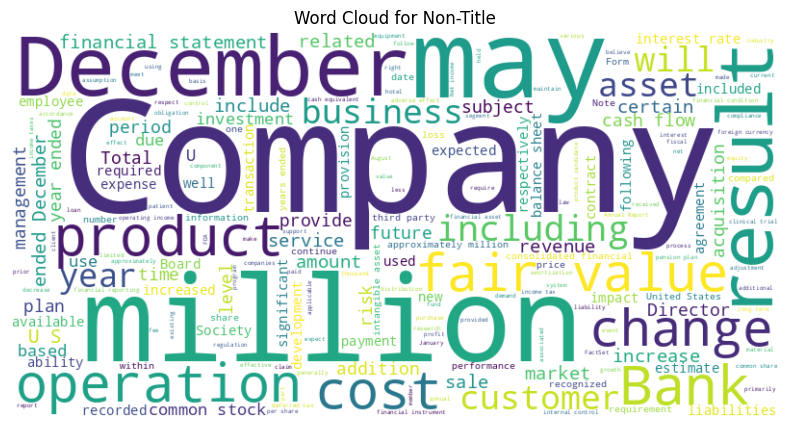

In [125]:
from wordcloud import WordCloud

text = ' '.join(df_train[df_train['Label'] == 1]['Text'].astype(str))


wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Title')
plt.show()



text = ' '.join(df_train[df_train['Label'] == 0]['Text'].astype(str))
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Title')
plt.show()

Feature Correlation


<ipython-input-131-98e27edefabc>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



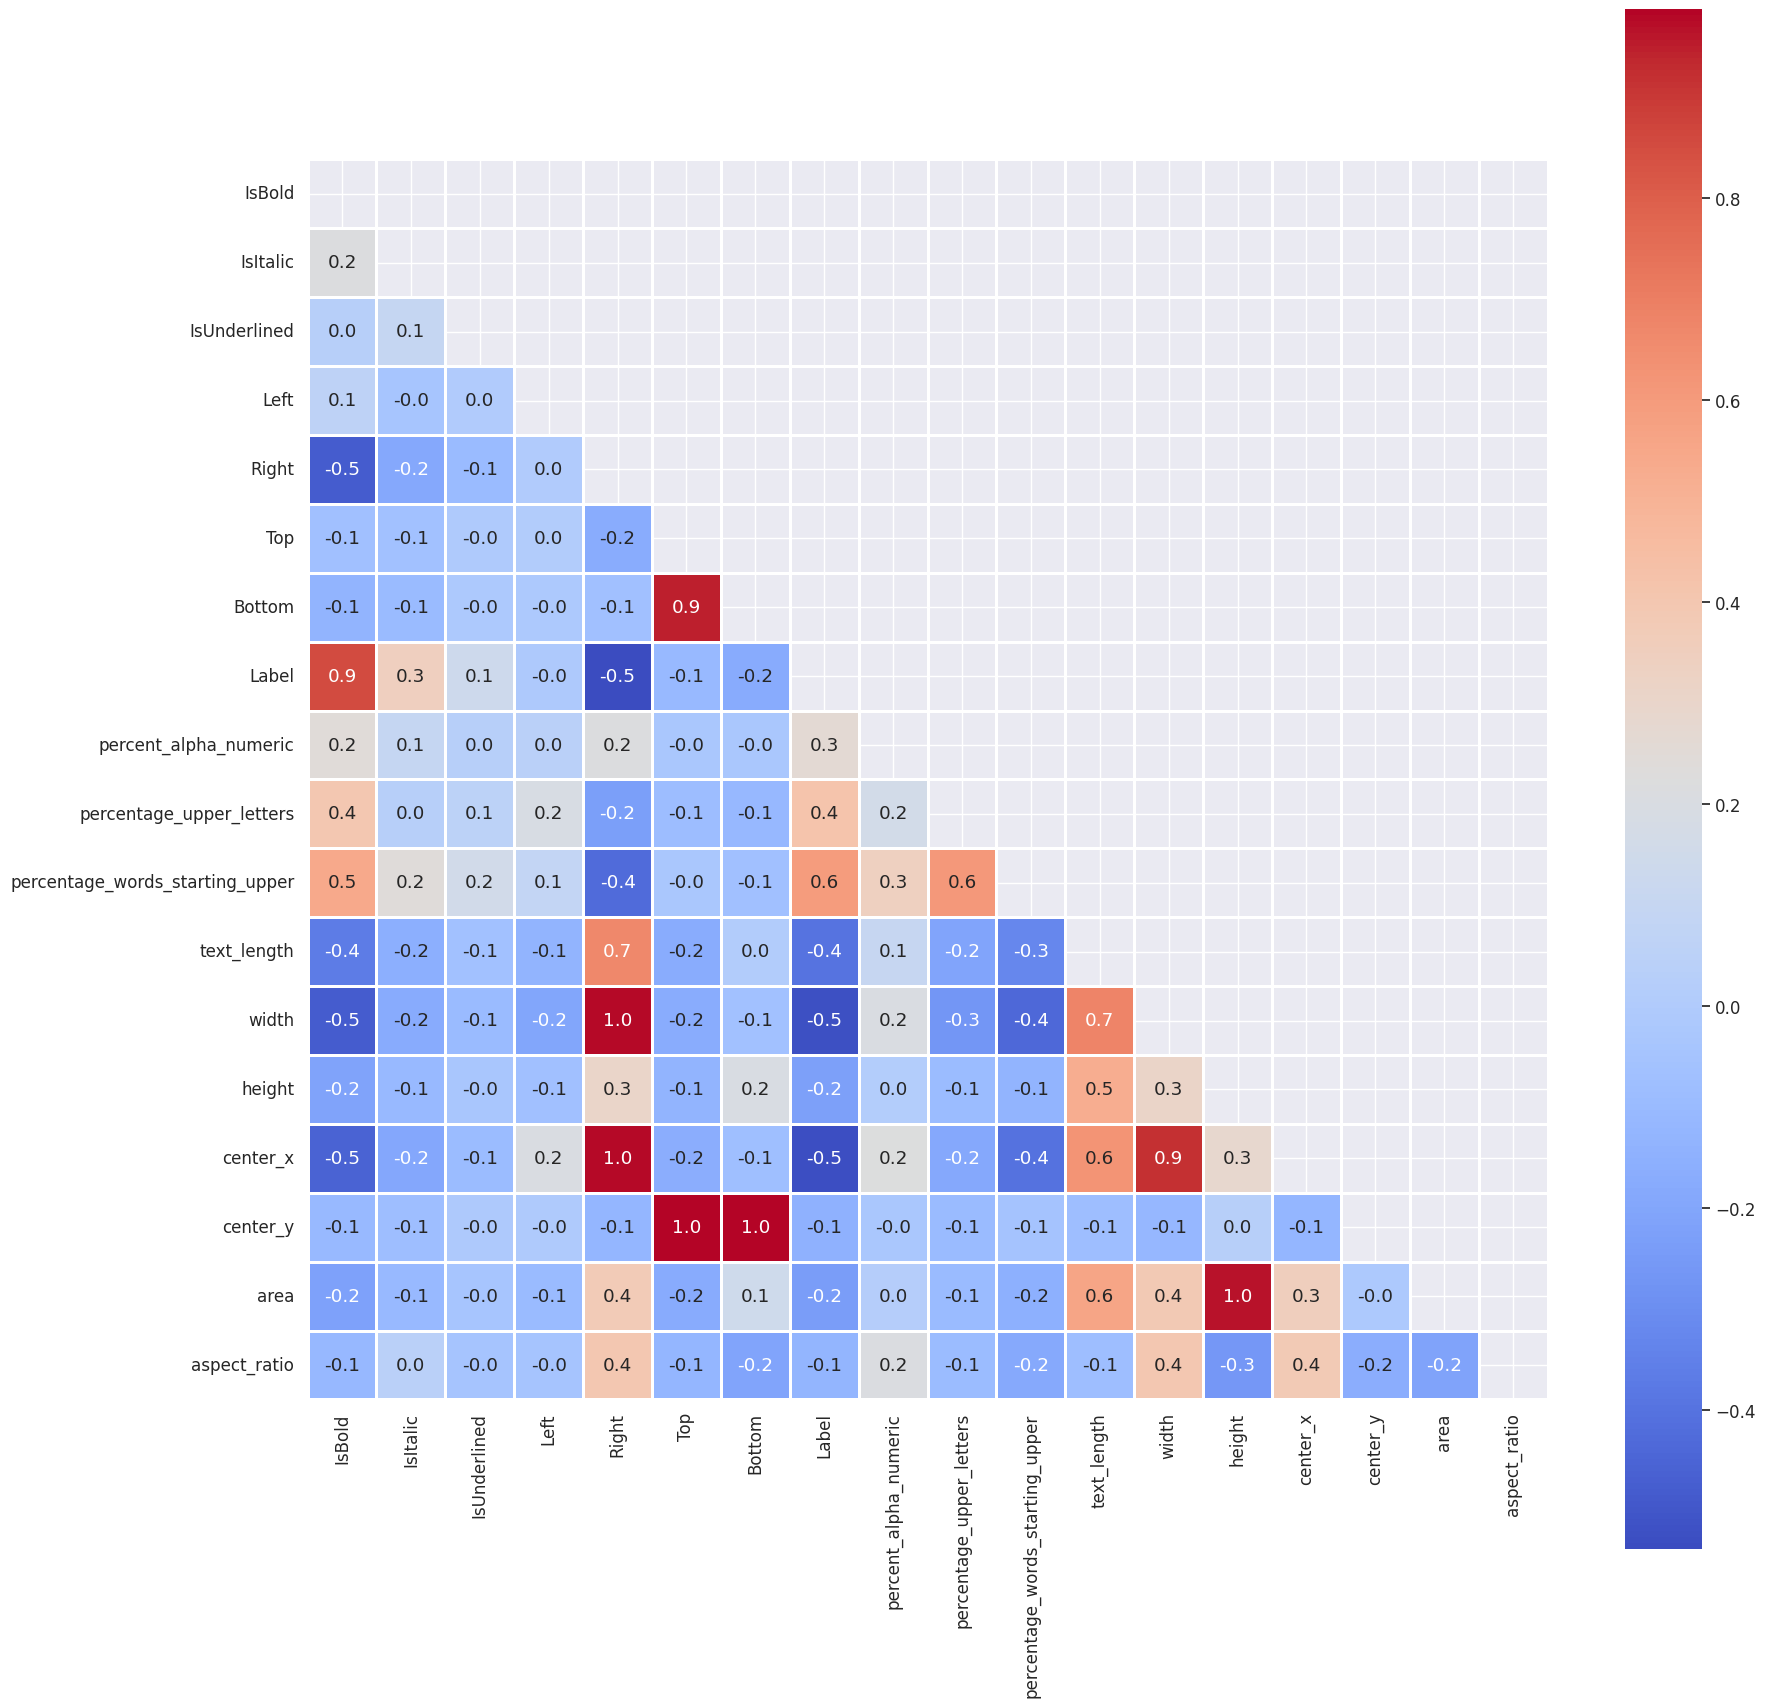

In [131]:
import plotly.express as px

corr_train = df_train.corr()

# create heatmap figure using Plotly
sns.set(font_scale=1.1)
mask = np.triu(corr_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(corr_train, annot=True, fmt='.1f', cmap='coolwarm', square=True, mask=mask, linewidth=1, cbar=True)
plt.show()

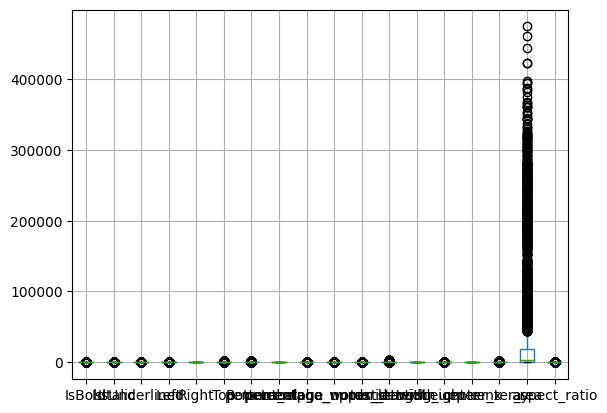

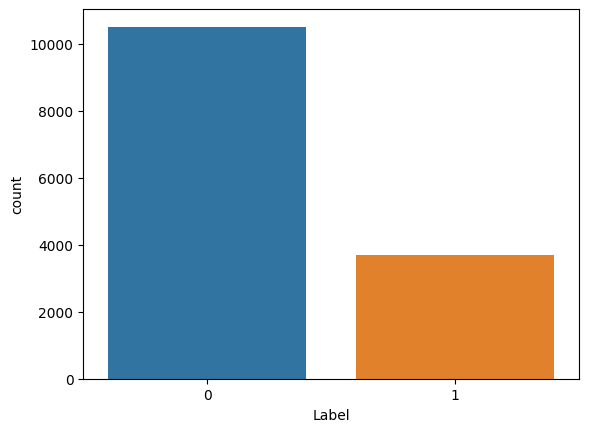

In [127]:
df_train.boxplot()
plt.show()

sns.countplot(x='Label', data=df_train)
plt.show()

In [128]:
df_train.head()

,Text,IsBold,IsItalic,IsUnderlined,Left,Right,Top,Bottom,Label,percent_alpha_numeric,percentage_upper_letters,percentage_words_starting_upper,text_length,width,height,center_x,center_y,area,aspect_ratio
0,NOTES TO THE ACCOUNTS FOR THE 52 WEEK PERIOD E...,1,0,0,49.5,544.0,67.3,96.1,1,81.818182,71.212121,76.923077,66,494.5,28.8,296.75,81.70,14241.60,17.170139
1,DERIVATIVE INSTRUMENTS,0,0,0,41.5,140.2,49.0,54.7,1,95.454545,95.454545,100.000000,22,98.7,5.7,90.85,51.85,562.59,17.315789
2,-6,0,0,0,113.5,122.2,409.3,414.9,0,50.000000,0.000000,0.000000,2,8.7,5.6,117.85,412.10,48.72,1.553571
3,The following performance graph and related in...,0,0,0,112.9,706.9,339.0,360.3,0,81.333333,3.619048,19.767442,525,594.0,21.3,409.90,349.65,12652.20,27.887324
4,Typical service offerings include supply chain...,0,0,0,33.1,808.5,328.2,369.9,0,84.919887,1.696513,9.375000,1061,775.4,41.7,420.80,349.05,32334.18,18.594724


Feature Normalization

In [129]:

from sklearn.preprocessing import StandardScaler

numerical_columns = ['Left', 'Right', 'Top', 'Bottom', 'text_length',  'width', 'height',
       'center_x', 'center_y', 'area', 'aspect_ratio']


scaler = StandardScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

Classification with LightGBM

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

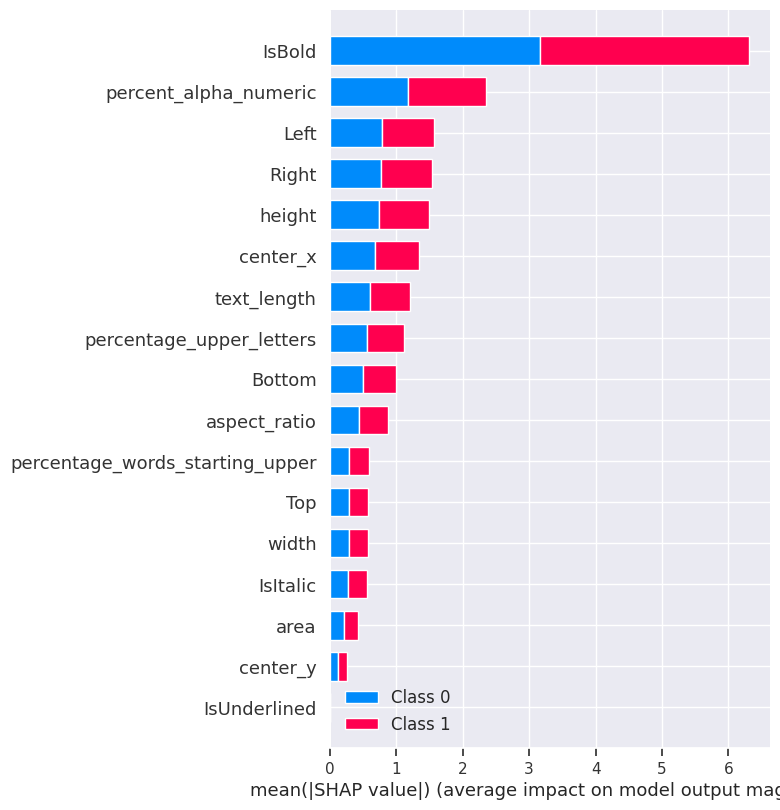

Results on test data
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Best Parameters: {'num_leaves': 50, 'n_estimators': 200, 'min_data_in_leaf': 600, 'max_depth': 5, 'learning_rate': 0.2}
Test Accuracy: 0.9905029897995076
Precision: 0.9679284963196635
Recall: 0.9964817320703654
F1-Score: 0.9819975996799574
Confusion Matrix:
 [[10398   122]
 [   13  3682]]


LGBMClassifier(is_unbalance=True, metric='binary_logloss', objective='binary')

In [144]:
import warnings
import shap

warnings.filterwarnings("ignore")

def classification():

  X = df_train.drop(['Label', 'Text'], axis=1)
  y = df_train['Label']


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)


  param_grid = {
      'n_estimators': [200],
      'learning_rate': [0.1, 0.2],
      'max_depth': [4, 5],
      'num_leaves': [40, 50],
      'min_data_in_leaf': [500, 600],

  }


  clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', is_unbalance=True)
  search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=5, scoring='accuracy', random_state=2018)
  search.fit(X_train, y_train)

  best_params = search.best_params_
  best_model = search.best_estimator_

  y_pred = best_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  print('Results on train data')
  print("Best Parameters:", best_params)
  print("Test Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("Confusion Matrix:\n", conf_matrix)

  explainer = shap.TreeExplainer(best_model)

  shap_values = explainer.shap_values(X_train)
  shap.summary_plot(shap_values, X_train)


  X_test = df_test.drop(['Label', 'Text'], axis=1)
  y_test = df_test['Label']

  print('Results on test data')
  y_pred = best_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  print("Best Parameters:", best_params)
  print("Test Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("Confusion Matrix:\n", conf_matrix)

  return clf

classification()

Utilize text data

In [107]:
!pip install sentence_transformers

In [145]:
from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
df_train['embeddings'] = df_train['Text'].apply(lambda x: st_model.encode([x[:1024]])[0])
df_test['embeddings'] = df_test['Text'].apply(lambda x: st_model.encode([x[:1024]])[0])

In [146]:
vector_column = df_train['embeddings']
vector_df = pd.DataFrame(list(vector_column), columns=[f'Feature_{i+1}' for i in range(vector_column.iloc[0].shape[0])])
df_train = pd.concat([df_train, vector_df], axis=1)

vector_column = df_test['embeddings']
vector_df1 = pd.DataFrame(list(vector_column), columns=[f'Feature_{i+1}' for i in range(vector_column.iloc[0].shape[0])])
df_test = pd.concat([df_test, vector_df1], axis=1)

In [ ]:
# Test Accuracy: 0.9841716496658459
# Precision: 0.9678321678321679
# Recall: 0.969187675070028
# F1-Score: 0.9685094471658503
# Confusion Matrix:
#  [[2106   23]
#  [  22  692]]
# [LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
# Best Parameters: {'num_leaves': 60, 'n_estimators': 400, 'min_data_in_leaf': 600, 'max_depth': 5, 'learning_rate': 0.1}
# Test Accuracy: 0.9964825888146325
# Precision: 0.9924344771683329
# Recall: 0.9940460081190798
# F1-Score: 0.9932395889670093
# Confusion Matrix:
#  [[10492    28]
#  [   22  3673]]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

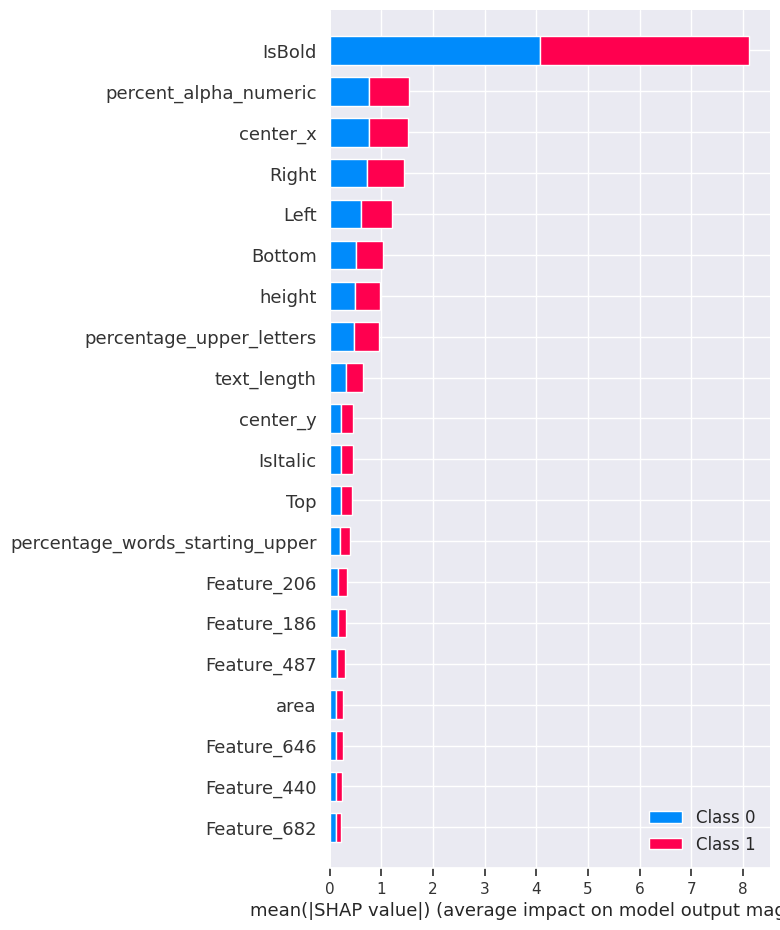

Results on test data
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Best Parameters: {'num_leaves': 50, 'n_estimators': 200, 'min_data_in_leaf': 500, 'max_depth': 5, 'learning_rate': 0.2}
Test Accuracy: 0.9966936334857545
Precision: 0.9921748515920129
Recall: 0.995128552097429
F1-Score: 0.9936495068234023
Confusion Matrix:
 [[10491    29]
 [   18  3677]]


LGBMClassifier(is_unbalance=True, metric='binary_logloss', objective='binary')

In [147]:
df_train1 = df_train.copy()
df_test1 = df_test.copy()
df_train = df_train.drop(['embeddings'], axis=1)
df_test = df_test.drop(['embeddings'], axis=1)
classification()

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

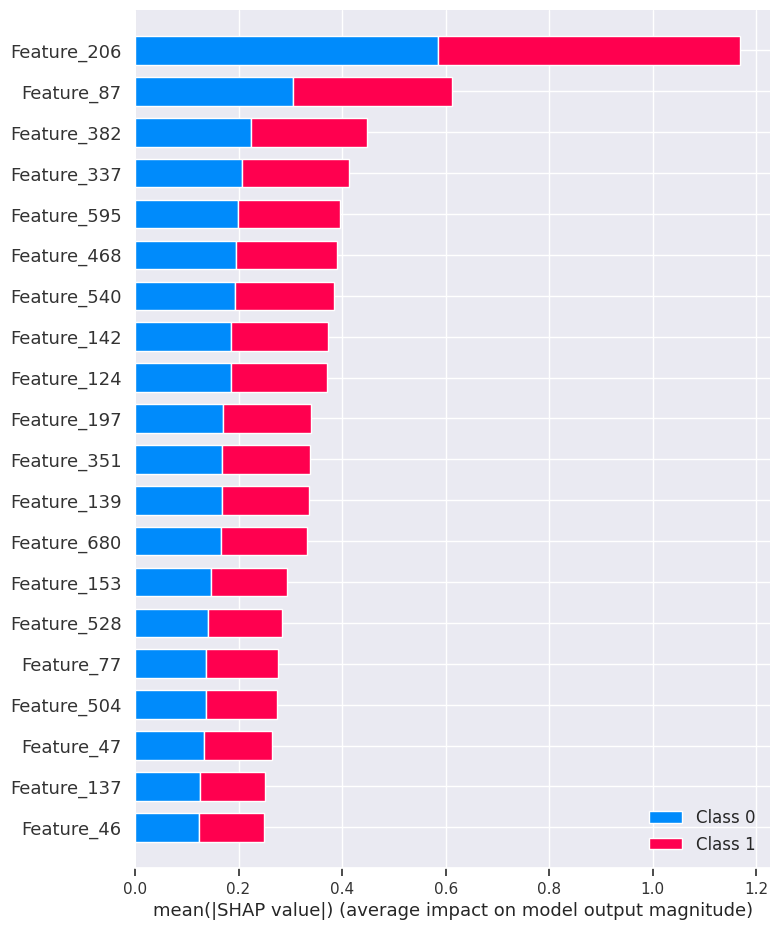

Results on test data
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Best Parameters: {'num_leaves': 50, 'n_estimators': 200, 'min_data_in_leaf': 600, 'max_depth': 5, 'learning_rate': 0.2}
Test Accuracy: 0.9744635947942314
Precision: 0.9252169474221542
Recall: 0.9810554803788903
F1-Score: 0.9523184027321687
Confusion Matrix:
 [[10227   293]
 [   70  3625]]


LGBMClassifier(is_unbalance=True, metric='binary_logloss', objective='binary')

In [148]:

df_test = pd.concat([df_test[['Label', 'Text']], vector_df1], axis=1)
df_train = pd.concat([df_train[['Label', 'Text']], vector_df], axis=1)

classification()